In [1]:
!pip install -q kaggle


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets list

ref                                                             title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                             Online Food Dataset                               3KB  2024-03-02 18:50:30          27116        528  0.9411765        
nbroad/gemma-rewrite-nbroad                                     gemma-rewrite-nbroad                              8MB  2024-03-03 04:52:39           1684        105  1.0              
startalks/pii-models                                            pii-models                                        1GB  2024-03-21 21:23:40            142         20  1.0              
sukhmandeepsinghbrar/most-subscribed-youtube-channel            Most Subscribed 

In [6]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [00:56<00:00, 157MB/s]
100% 5.20G/5.20G [00:56<00:00, 99.2MB/s]


In [7]:
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_part_2/ISIC_0029342.jpg  
  inflating: h

In [8]:
!pip install torchinfo

In [9]:
import pandas as pd
import numpy as np
import torch
import os
import shutil
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader, Subset
from transformers import ConvNextForImageClassification
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from torchinfo import summary
from PIL import Image

In [10]:
def combine_folders(src1, src2, dest):

    copied_files = []  # List to store names of successfully copied files

    # Create folder when destination folder not exist, exit function if destination folder contains contents from the source folder
    if not os.path.exists(dest):
      print(f"Destination folder {dest} created...")
      os.makedirs(dest)

    else:
      # Recreate folder when destination folder do not have all the contents in source folders to avoid overlapping contents
      if len(os.listdir(dest)) == (len(os.listdir(src1)) + len(os.listdir(src2))):
        print("Content in source 1 folder and source 2 folder have been copied to destination folder")

        for filename in os.listdir(dest):
            copied_files.append(filename)

        return copied_files

      else:
        shutil.rmtree(dest)
        os.makedirs(dest)


    print(f"Copying images in {src1} into {dest}...")

    # Loop through all content in source folder 1 and copy into destination folder, if source 1 folder exist
    if os.path.exists(src1):
      print('Source 1 folder consist of ', len(os.listdir(src1)), " elements")

      for images in os.listdir(src1):

        # Define the source path and the destination path for each images
        src_path = os.path.join(src1, images)
        dest_path = os.path.join(dest, images)

        # Copy to the destination folder
        shutil.copy(src_path, dest_path)
        copied_files.append(images)

      print(f"All images in {src1} have been copied into {dest}...")

    else:
      print(f"{src1} not found")


    print(f"Copying images in {src2} into {dest}...")

    # loop through all content in source folder 2 and copy into destination folder, if source 2 folder exist
    if os.path.exists(src2):
      print('Source 2 folder consist of ', len(os.listdir(src2)), " elements")

      for images in os.listdir(src2):

        # Define the source path and the destination path for each images
        src_path = os.path.join(src2, images)
        dest_path = os.path.join(dest, images)

        # Copy to the destination folder
        shutil.copy(src_path, dest_path)
        copied_files.append(images)

      print(f"All images in {src2} have been copied into {dest}...")

    else:
      print(f"{src2} not found")

    print('Destination folder consist of ', len(os.listdir(dest)), " elements")

    return copied_files

In [11]:
src1 = "HAM10000_images_part_1"
src2 = "HAM10000_images_part_2"
dest = "Dataset"
copied_files = combine_folders(src1, src2, dest)

Destination folder Dataset created...
Copying images in HAM10000_images_part_1 into Dataset...
Source 1 folder consist of  5000  elements
All images in HAM10000_images_part_1 have been copied into Dataset...
Copying images in HAM10000_images_part_2 into Dataset...
Source 2 folder consist of  5015  elements
All images in HAM10000_images_part_2 have been copied into Dataset...
Destination folder consist of  10015  elements


In [12]:
train_file = "HAM10000_metadata.csv"
skin_train_df = pd.read_csv(train_file)

skin_train_df['image_id_with_extension'] = skin_train_df['image_id'] + '.jpg'
skin_train_df = skin_train_df[skin_train_df['image_id_with_extension'].isin(copied_files)]
skin_train_df = skin_train_df.drop(columns=['image_id_with_extension'])

skin_train_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [13]:
print("Null counts for each attribute:")
print(skin_train_df.isnull().sum())
print()

print("Counts of 'unknown' for each attribute:")
print((skin_train_df == 'unknown').sum())

# Drop rows with null or 'unknown' values for EDA purpose
skin_df = skin_train_df.dropna()
skin_df = skin_df[(skin_train_df != 'unknown').all(axis=1)]

Null counts for each attribute:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Counts of 'unknown' for each attribute:
lesion_id         0
image_id          0
dx                0
dx_type           0
age               0
sex              57
localization    234
dtype: int64


<ipython-input-13-f04e56bbce39>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  skin_df = skin_df[(skin_train_df != 'unknown').all(axis=1)]


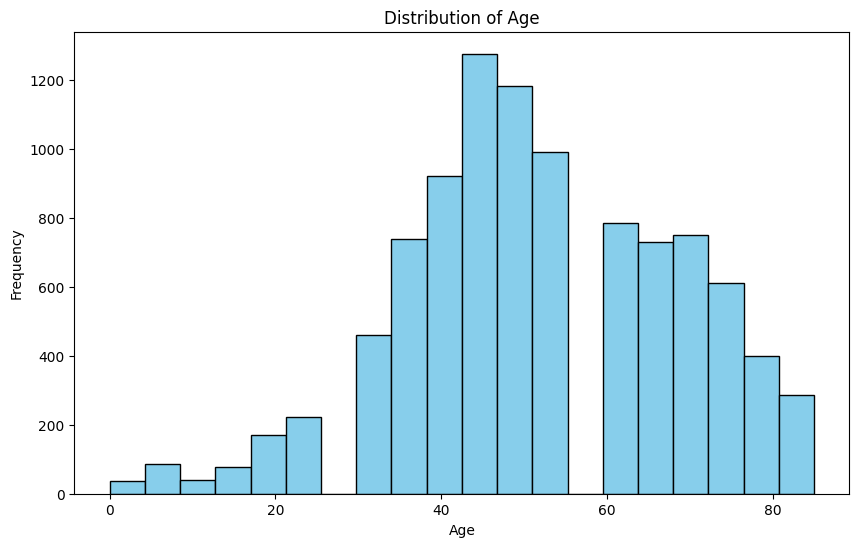

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(skin_df['age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

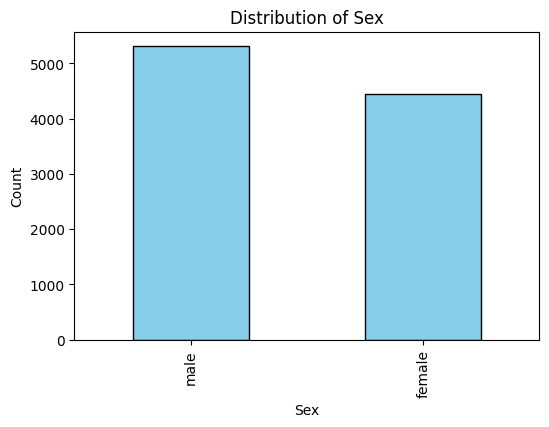

In [15]:
plt.figure(figsize=(6, 4))
skin_df['sex'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Distribution of Sex')
plt.show()

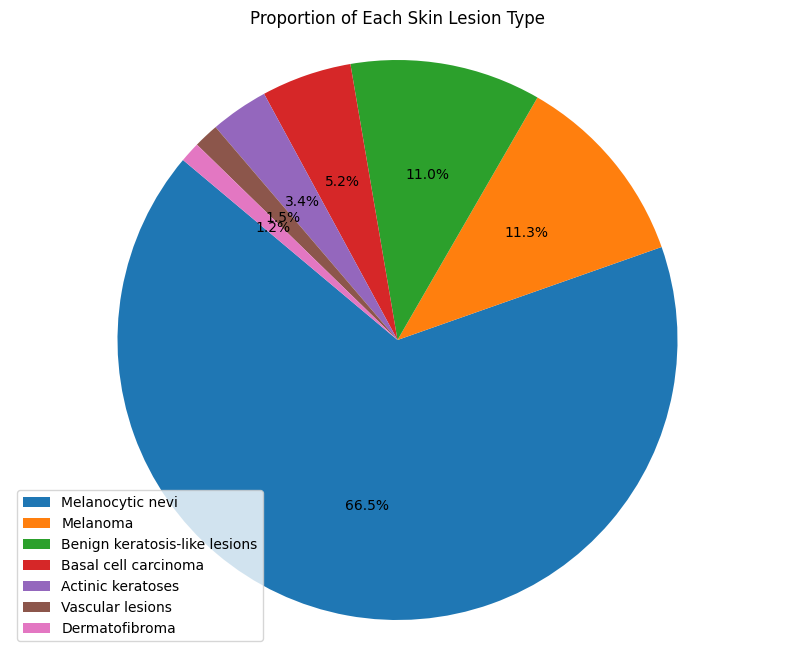

In [16]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Get the counts of each lesion type
lesion_type_counts = skin_df['dx'].value_counts()

# Create labels and sizes for the pie chart
labels = [lesion_type_dict[code] for code in lesion_type_counts.index]
sizes = lesion_type_counts.values

# Create the pie chart with percentage labels
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=None, startangle=140, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of Each Skin Lesion Type')

# Add a legend based on color
plt.legend(labels, loc="best")
plt.show()

In [17]:
skin_train_df = skin_train_df.drop(['lesion_id', 'dx_type', 'age', 'sex', 'localization'], axis=1)
skin_train_df.head(5)

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [18]:
print('Shape of train_df : ', skin_train_df.shape, '\n')

Shape of train_df :  (10015, 2) 



In [19]:
class HAM10000(Dataset):
    def __init__(self, df, root, train_mode=True):

        self.data = []
        self.targets = []
        self.df = df
        self.root = root
        self.train_mode = train_mode

        # Transform the images
        self.transform = transforms.Compose([
            transforms.Resize(384),
            transforms.RandomRotation(20),  # Random rotation between -20 to 20 degrees
            transforms.RandomHorizontalFlip(),  # Random horizontal flip
            transforms.RandomVerticalFlip(),  # Random vertical flip
            transforms.ToTensor(),  # Convert to PyTorch Tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
        ])

        # append filepath to data and integer labels to targets
        for idx in range(len(self.df)):
            filename = self.df['image_id'].iloc[idx]
            filepath = os.path.join(root, filename + '.jpg')
            self.data.append(filepath)
            target = self.label_to_int(self.df['dx'].iloc[idx])
            self.targets.append(target)

    def __len__(self):
        return len(self.df)

    # get integer that represent a class
    def label_to_int(self, label):
        label_dict = {
            'nv': 0,      # Melanocytic nevi
            'mel': 1,     # Melanoma
            'bkl': 2,     # Benign keratosis-like lesions
            'bcc': 3,     # Basal cell carcinoma
            'akiec': 4,   # Actinic keratoses
            'vasc': 5,    # Vascular lesions
            'df': 6       # Dermatofibroma
        }

        return label_dict.get(label, -1)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        label = self.targets[idx]

        return image, label

    def split_train_test(self, train_ratio=0.9):
        train_size = int(train_ratio * len(self))
        test_size = len(self) - train_size
        train_set, test_set = torch.utils.data.random_split(self, [train_size, test_size])

        return train_set, test_set

In [20]:
trainset = HAM10000(skin_train_df, "Dataset", train_mode=True)
trainset, testset = trainset.split_train_test(train_ratio=0.9)

In [21]:
print(f"Train set contains : {len(trainset)}\n")
print(f"Test set contains : {len(testset)}\n")

Train set contains : 9013

Test set contains : 1002



In [23]:
def make_weights_for_balanced_classes(dataset):

    # Get class distribution for each classes
    class_counts = dataset.df['dx'].value_counts()

    # Get the length for the dataset
    num_samples = len(dataset)

    # Get weights for each classes by dividing the total number of samples in dataset by the total samples of specific class
    class_weights = {i: num_samples/class_counts[i] for i in range(len(class_counts))}

    # Assign weights to each samples based on their classes
    weights = [class_weights[label] for label in dataset.targets]

    return weights

In [24]:
weights = make_weights_for_balanced_classes(trainset.dataset)
sampler = WeightedRandomSampler(weights, len(weights))

# Create DataLoaders sand use the sampler to sampling the data
trainloader = DataLoader(trainset, batch_size=8, sampler=sampler)
testloader = DataLoader(testset, batch_size=8, shuffle=True)

In [25]:
def train(model, dataloader, device, num_epochs, lr=0.1, momentum=0.8, step_size=5, gamma=0.5, verbose=True):

    history = []
    loss_iterations = int(np.ceil(len(dataloader)/3))

    model = model.to(device)

    # set the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # set the scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    model.train()

    for e in range(num_epochs):

        running_loss = 0.0
        running_count = 0.0

        for i, (inputs, labels) in enumerate(dataloader):

            optimizer.zero_grad()

            if torch.cuda.is_available():
                inputs = inputs.to(device)
                labels = labels.to(device)

            labels = labels.reshape(-1, 1).float()

            outs = model(inputs)
            loss = nn.CrossEntropyLoss()(outs, labels.squeeze().long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_count += 1

            if (i + 1) % loss_iterations == 0 or i == len(dataloader) - 1:
                train_loss = running_loss / running_count
                running_loss = 0.
                running_count = 0.
                if verbose:
                    print(f'[Epoch {e+1:2d}/{num_epochs:d} Iter {i+1:5d}/{len(dataloader)}]: train_loss = {train_loss:.4f}')

                history.append(train_loss)

        # Free memory after each epoch
        del inputs, labels, outs, loss  # Delete intermediate variables

        if torch.cuda.is_available():
            torch.cuda.empty_cache()  # Empty PyTorch cache on GPU

        # update scheduler
        scheduler.step()

    return history

In [26]:
def evaluate(net, dataloader, device):
    # set to evaluation mode
    net.eval()

    # running_correct
    running_corrects = 0
    all_targets = []
    all_predicted = []

    for inputs, targets in dataloader:

        # transfer to the GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()

        # perform prediction (no need to compute gradient)
        with torch.no_grad():
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            running_corrects += (targets == predicted).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    acc = running_corrects / len(dataloader.dataset)

    print(f'Accuracy: {acc:.2f}')

    # Calculate confusion matrix
    cm = confusion_matrix(all_targets, all_predicted)

    # Display confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(7)], yticklabels=[str(i) for i in range(7)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute and display classification report
    report = classification_report(all_targets, all_predicted, target_names=[str(i) for i in range(7)])
    print("Classification Report:")
    print(report)

In [27]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=7)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 93.6MB/s]


In [28]:
freeze_layers = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3']

# Iterate over named modules and freeze/unfreeze as required
for name, module in model.named_children():
    if name in freeze_layers:
        for param in module.parameters():
            param.requires_grad = False
    else:
        for param in module.parameters():
            param.requires_grad = True

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history = train(model, testloader, device, num_epochs=15, lr=0.1, momentum=0.8, step_size=5, gamma=0.5)

[Epoch  1/15 Iter    42/126]: train_loss = 2.3598
[Epoch  1/15 Iter    84/126]: train_loss = 2.0269
[Epoch  1/15 Iter   126/126]: train_loss = 2.0486
[Epoch  2/15 Iter    42/126]: train_loss = 1.0508
[Epoch  2/15 Iter    84/126]: train_loss = 0.9868
[Epoch  2/15 Iter   126/126]: train_loss = 0.9379
[Epoch  3/15 Iter    42/126]: train_loss = 0.8794
[Epoch  3/15 Iter    84/126]: train_loss = 0.8725
[Epoch  3/15 Iter   126/126]: train_loss = 0.7398
[Epoch  4/15 Iter    42/126]: train_loss = 0.8001
[Epoch  4/15 Iter    84/126]: train_loss = 0.7323
[Epoch  4/15 Iter   126/126]: train_loss = 0.7962
[Epoch  5/15 Iter    42/126]: train_loss = 0.7629
[Epoch  5/15 Iter    84/126]: train_loss = 0.7968
[Epoch  5/15 Iter   126/126]: train_loss = 0.7028
[Epoch  6/15 Iter    42/126]: train_loss = 0.7726
[Epoch  6/15 Iter    84/126]: train_loss = 0.6184
[Epoch  6/15 Iter   126/126]: train_loss = 0.5839
[Epoch  7/15 Iter    42/126]: train_loss = 0.6168
[Epoch  7/15 Iter    84/126]: train_loss = 0.6060


Accuracy: 0.89


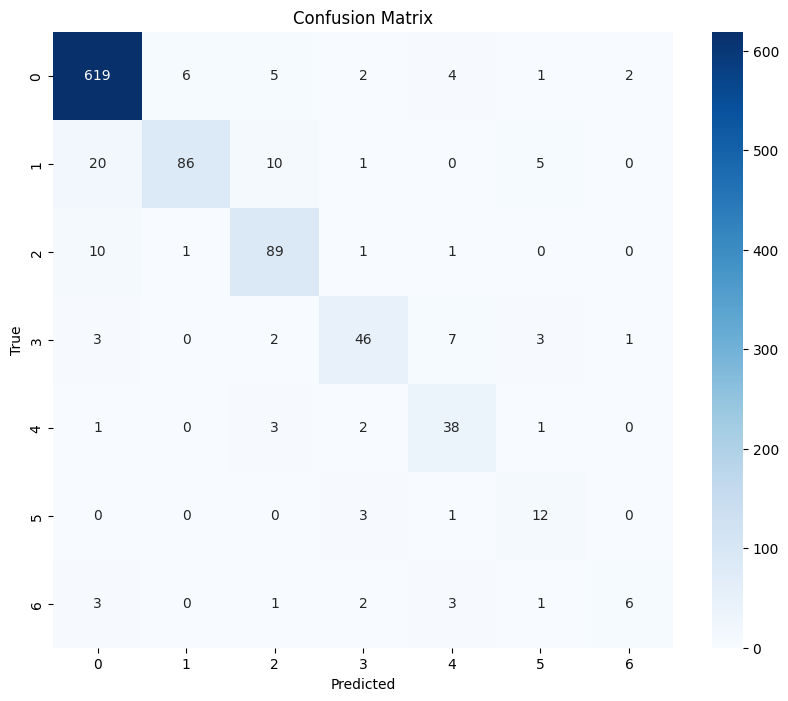

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       639
           1       0.92      0.70      0.80       122
           2       0.81      0.87      0.84       102
           3       0.81      0.74      0.77        62
           4       0.70      0.84      0.77        45
           5       0.52      0.75      0.62        16
           6       0.67      0.38      0.48        16

    accuracy                           0.89      1002
   macro avg       0.77      0.75      0.75      1002
weighted avg       0.90      0.89      0.89      1002



In [30]:
evaluate(model, testloader, device)

In [ ]:
save_path = "method2_resnet50.pth"
# Save the trained model
torch.save(model.state_dict(), save_path)